<h1 align="center"> Image Captioning </h1>

## Data preprocessing


In [1]:
!pip install scipy==1.1.0 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 147 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 4.1.4 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.1.0 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
jax 0.3.25 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
aeppl 0.0.33 requires scipy>=1.4.0, but you have scipy 1.1.0 which is incompatible.


In [2]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [ ]:
import numpy as np
import json

# load the dataset
img_codes = np.load("gdrive/My Drive/Deep_Learning/dls_spring_2020/image_captioning/data/image_codes.npy")
captions = json.load(open('gdrive/My Drive/Deep_Learning/dls_spring_2020/image_captioning/data/captions_tokenized.json'))

In [ ]:
# check correctness
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [ ]:
captions[0]

['people shopping in an open market for vegetables .',
 'an open market full of people and piles of vegetables .',
 'people are shopping at an open air produce market .',
 'large piles of carrots and potatoes at a crowded outdoor market .',
 'people shop for vegetables like carrots and potatoes at an open air market .']

In [ ]:
!pip install youtokentome

In [ ]:
import youtokentome as yttm
import matplotlib.pyplot as plt


In [ ]:
# count statistics on the length of descriptions
sent_lenghts = np.zeros(5*len(captions), dtype='int')
i = 0
for sents in captions:
    for sent in sents:
        sent_lenghts[i] = int(len(sent))
        i += 1

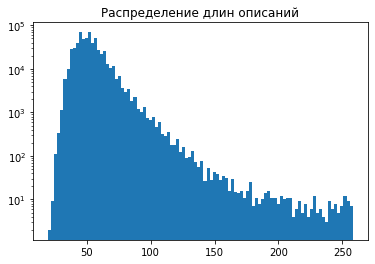

In [ ]:
plt.hist(sent_lenghts, bins = 100)
plt.title('Распределение длин описаний')
plt.yscale('log')

In [ ]:
max_sent_lenght = 200

In [ ]:
all_sents = []
for sents in captions:
    for sent in sents:
        all_sents.append(sent[:max_sent_lenght])

In [ ]:
len(all_sents)

591435

In [ ]:
!mkdir BPE

mkdir: cannot create directory ‘BPE’: File exists


In [ ]:
with open('/content/BPE/train_data.txt', "w") as fout:
    for sent in all_sents:
        print(sent, file=fout)

In [ ]:
yttm.BPE.train(data='/content/BPE/train_data.txt', model='/content/BPE/model',vocab_size=1000)

In [ ]:
tokenizer = yttm.BPE('/content/BPE/model')

In [ ]:
# print(' '.join(tokenizer.vocab()))

In [ ]:
encoded_all_sents = tokenizer.encode(all_sents, bos=True, eos=True)

In [ ]:
# add <PAD>
tokenized_captions = []
for tokenized_sent in encoded_all_sents:
    tokenized_captions.append(tokenized_sent + [0]*(max_sent_lenght-len(tokenized_sent)))

In [ ]:
tokenized_captions = np.array(tokenized_captions).reshape((-1, 5, 200))

In [ ]:
tokenized_captions.shape

(118287, 5, 200)

### RNN for text description generation

Let's write a network that will receive CNN network outputs (image embeddings) and convert them into text.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens, max_len, device, emb_size=128, lstm_units=256,
                 cnn_feature_size=2048, num_LSTM_layers=1, dropout=0, teacher_forcing=True):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.emb_size = emb_size
        self.lstm_units = lstm_units
        self.cnn_feature_size = cnn_feature_size
        self.num_LSTM_layers = num_LSTM_layers
        self.max_len = max_len
        self.device = device
        self.teacher_forcing = teacher_forcing
        # two linear layers that will make the initial states h0 and c0 for the
        # LSTM from the vectors obtained from the Inseption output 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, num_LSTM_layers*lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, num_LSTM_layers*lstm_units)
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=0)

        self.rnn = nn.LSTM(emb_size, lstm_units, num_layers=num_LSTM_layers, batch_first=True)

        self.out = nn.Linear(lstm_units, n_tokens)
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, image_vectors, captions_ix):
        """ 
        :param image_vectors: torch tensor, containing the outputs of Inseption.
                shape: [batch, cnn_feature_size]
        :param captions_ix: target image description,  shape: [batch, word_i]

        :returns: logits for generated text description, shape: [batch, word_i, n_tokens]
        """
        batch_size = captions_ix.shape[0]
        input_len = captions_ix.shape[1]
        # initial_cell and initial_hid
        cell = self.cnn_to_c0(image_vectors).view(batch_size, self.num_LSTM_layers, -1).transpose(1,0).contiguous()
        hidden = self.cnn_to_h0(image_vectors).view(batch_size, self.num_LSTM_layers, -1).transpose(1,0).contiguous()
        

        if self.teacher_forcing:
            captions_emb = self.emb(captions_ix)
            output, (hidden, cell) = self.rnn(captions_emb, (hidden, cell))
            logits = self.out(output)
            assert logits.shape == (batch_size, input_len, self.n_tokens)

        else:
            # the first token from captions_ix, i.e. <BOS>
            first_caption = captions_ix[:, 0]
            captions_emb = self.emb(first_caption)

            logits = torch.zeros(self.max_len, batch_size, self.n_tokens).to(self.device)

            for t in range(self.max_len):
                output, (hidden, cell) = self.rnn(captions_emb, (hidden, cell))
                logits[t] = self.out(output)
                captions_emb = self.emb(output.max(1)[1])
                
            assert logits.shape == (batch_size, input_len, self.n_tokens)
            
        return logits        

In [ ]:
DEVICE = torch.device('cuda')

In [ ]:
model = CaptionNet(n_tokens=tokenizer.vocab_size(), max_len=max_sent_lenght, device=DEVICE,
                   num_LSTM_layers=2)
model.to(DEVICE)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing the outputs of Inseption. 
            shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor, target image description. shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    logits_flat = logits_for_next.view(-1, logits_for_next.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = captions_ix_next.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(logits_flat, target_flat, ignore_index=0)
    

train/test split:

In [ ]:
from sklearn.model_selection import train_test_split

train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, tokenized_captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [ ]:
train_data = (train_img_codes, train_captions)
valid_data = (val_img_codes, val_captions)

In [ ]:
# batch generator
from random import choice

def generate_batch(img_codes, captions, batch_size, device):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = np.array(batch_captions)
    
    return torch.tensor(batch_images, dtype=torch.float32, device=device), torch.tensor(batch_captions_ix, dtype=torch.int64, device=device)
    

## Train it

In [ ]:
from IPython.display import clear_output

In [ ]:
def train(model, optimizer, train_data, val_data, batch_generator, num_iterations, batch_size, device):
    train_img_codes, train_target = train_data
    val_img_codes, val_target = val_data
    best_valid_loss = float('inf')
    train_loss_history = []
    train_history = []
    valid_history = []
    for t in range(num_iterations):
        
        optimizer.zero_grad()
        model.train()
        train_batch =  generate_batch(train_img_codes, train_target, batch_size, device)
        train_loss = compute_loss(model, train_batch[0], train_batch[1])
        train_loss.backward()
        optimizer.step()
        train_loss_history.append(train_loss.cpu().data.numpy())

        if t % 10 == 0 and t > 0:
            model.eval()
            val_batch =  generate_batch(val_img_codes, val_target, batch_size, device)
            val_loss = compute_loss(model, val_batch[0], val_batch[1])
            valid_history.append(val_loss.cpu().data.numpy())
            train_history.append(sum(train_loss_history[t-10:t])/10)

            if valid_history[-1] < best_valid_loss:
                best_valid_loss = valid_history[-1]
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
        clear_output(True)
        ax[0].plot(train_loss_history, label='train loss') 
        ax[0].set_xlabel('Batch') 
        ax[0].set_title('Train loss') 
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch') 
        ax[1].plot(valid_history, label='general valid history') 
        plt.legend()
        plt.show()
        
    return best_valid_loss

In [ ]:
def train_2(model, optimizer, train_data, val_data, batch_generator, num_iterations, batch_size, device):
    train_img_codes, train_target = train_data
    val_img_codes, val_target = val_data
    best_valid_loss = float('inf')
    train_loss_history = []
    train_history = []
    valid_history = []
    for t in range(num_iterations):
        
        optimizer.zero_grad()
        model.train()
        train_batch = generate_batch(train_img_codes, train_target, batch_size, device)
        train_loss = compute_loss(model, train_batch[0], train_batch[1])
        train_loss.backward()
        optimizer.step()
        train_loss_history.append(train_loss.cpu().data.numpy())

        if t % 30 == 0 and t > 0:
            model.eval()
            val_batch =  generate_batch(val_img_codes, val_target, batch_size, device)
            val_loss = compute_loss(model, val_batch[0], val_batch[1])
            valid_history.append(val_loss.cpu().data.numpy())
            train_history.append(sum(train_loss_history[t-29:])/30)

            if valid_history[-1] < best_valid_loss:
                best_valid_loss = valid_history[-1]
            if t % 90 == 0:
                print('_________________________________')
                print(f'Iteration {t}')
                print(f'train loss: {train_history[-1]}')
                print(f'valid loss: {valid_history[-1]}')
        
        # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
        # clear_output(True)
        # ax[0].plot(train_loss_history, label='train loss') 
        # ax[0].set_xlabel('Batch') 
        # ax[0].set_title('Train loss') 
        # ax[1].plot(train_history, label='general train history')
        # ax[1].set_xlabel('Epoch') 
        # ax[1].plot(valid_history, label='general valid history') 
        # plt.legend()
        # plt.show()
        
    return best_valid_loss

In [ ]:
train_2(model, optimizer, train_data, valid_data, generate_batch, num_iterations=6000, batch_size=1000, device=DEVICE)

_________________________________
Iteration 90
train loss: 2.014957106113434
valid loss: 2.1138672828674316
_________________________________
Iteration 180
train loss: 2.012189515431722
valid loss: 2.094877004623413


KeyboardInterrupt: ignored

In [ ]:
!mkdir ModelsNotes

In [ ]:
torch.save(model.state_dict(), '/content/ModelsNotes/image_captioning(num_layers=2, emb_size=128,  lstm_units=256, cnn_feature_size=2048).pth')

## Inference with Inception


In [ ]:
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [ ]:
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


### Let's generate the descriptions

In [ ]:
def generate_caption(model, image, caption_prefix=2,
                     max_len=20, greedy_mode=True, temperature=None):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        model.eval()
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        vectors_neck = vectors_neck.to(DEVICE)
        caption_prefix = torch.LongTensor([caption_prefix]).unsqueeze(0).to(DEVICE)

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            predictions = model(vectors_neck, caption_prefix)
            if greedy_mode:
                caption_prefix = torch.cat((caption_prefix, predictions[0][-1].max(-1)[1][None, None]), dim = -1)
            else:
                if temperature == None:
                    temperature = 1

                next_token = torch.LongTensor([np.random.choice(1000, p=np.array(F.softmax(predictions[0][-1].cpu()/temperature), dtype='float32'))]).unsqueeze(0).to(DEVICE)
                caption_prefix = torch.cat((caption_prefix, next_token), dim = -1)
            if caption_prefix[0][-1] == 3:
                break
            
    return ' '.join(tokenizer.decode(list(caption_prefix)))

In [ ]:
from matplotlib import pyplot as plt
from scipy.misc import imresize

--2020-06-29 22:55:40--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-06-29 22:55:41--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   198KB/s    in 0.5s    

2020-06-29 22:55:42 (198 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


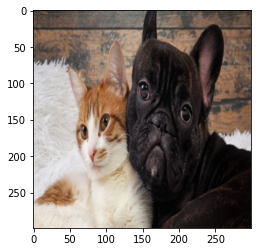

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a black and white cat is laying on a couch .<EOS>
<BOS> a dog with a hat standing in a field .<EOS>
<BOS> a black and white cat sitting on a couch .<EOS>
<BOS> a black dog is sitting on a couch .<EOS>
<BOS> a black and white cat sitting on a couch .<EOS>
<BOS> a small dog is sitting on a bed with a dog .<EOS>
<BOS> a dog sitting on a couch with a dog .<EOS>
<BOS> a small dog is sitting on a couch .<EOS>
<BOS> a black and white cat laying on a bed .<EOS>
<BOS> a cat laying on a bed with a dog .<EOS>


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:55:55--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.40.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.40.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-06-29 22:55:55--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.03s   

2020-06-29 22:55:55 (2.04 MB/s) - ‘img.jpg’ saved [54731/54731]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


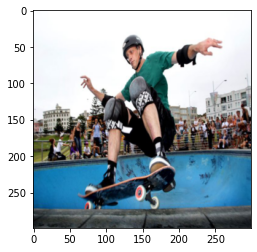

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a man riding a skateboard up a ramp .<EOS>
<BOS> a man riding a skateboard down a ramp .<EOS>
<BOS> a man riding a skateboard on top of a ramp .<EOS>
<BOS> a man is doing a trick on a skateboard .<EOS>
<BOS> a man on a skateboard doing a trick on a ramp .<EOS>
<BOS> a man riding a skateboard up the side of a ramp .<EOS>
<BOS> a man riding a skateboard on a ramp .<EOS>
<BOS> a man on a skateboard doing a trick on a ramp .<EOS>
<BOS> a man riding a skateboard down a ramp .<EOS>
<BOS> a man is doing a trick on a skateboard .<EOS>


In [ ]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:56:07--  https://i.pinimg.com/474x/f7/f0/4e/f7f04e6a71cf48ae0a3be09849db4dcd.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.193.24.222, 2600:1417:76:488::1931, 2600:1417:76:4a3::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.193.24.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60576 (59K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  59.16K  --.-KB/s    in 0.02s   

2020-06-29 22:56:08 (2.75 MB/s) - ‘img.jpg’ saved [60576/60576]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


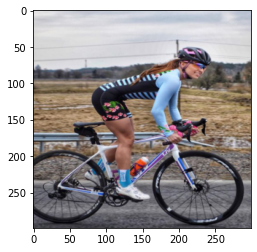

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a man riding a bike down a dirt road .<EOS>
<BOS> a man in a bikini riding a bicycle on a dirt road .<EOS>
<BOS> a man riding a bike down a dirt road .<EOS>
<BOS> a man riding a bicycle with a dog in the background .<EOS>
<BOS> a man riding a bike in the middle of a city .<EOS>
<BOS> a man riding a bike with a dog in the background .<EOS>
<BOS> a man riding a motorcycle down a street .<EOS>
<BOS> a man riding a bike on a ramp .<EOS>
<BOS> a man riding a bike down a dirt road .<EOS>
<BOS> a man riding a bike down a dirt road .<EOS>


In [ ]:
!wget https://i.pinimg.com/474x/f7/f0/4e/f7f04e6a71cf48ae0a3be09849db4dcd.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:56:34--  https://cdn.lifehacker.ru/wp-content/uploads/2012/07/01_1496913721-1140x570.jpg
Resolving cdn.lifehacker.ru (cdn.lifehacker.ru)... 136.243.37.177
Connecting to cdn.lifehacker.ru (cdn.lifehacker.ru)|136.243.37.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125641 (123K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 122.70K   115KB/s    in 1.1s    

2020-06-29 22:56:36 (115 KB/s) - ‘img.jpg’ saved [125641/125641]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


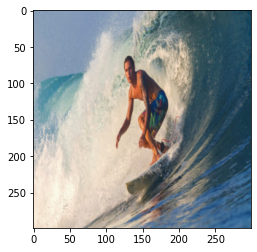

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a surfer in a white shirt is riding a wave .<EOS>
<BOS> a man riding a wave on a surfboard .<EOS>
<BOS> a surfer is riding a wave in the ocean .<EOS>
<BOS> a surfer is riding a wave in the ocean .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a surfer rides a wave in the ocean .<EOS>
<BOS> a man riding a wave on a surfboard .<EOS>
<BOS> a surfer riding a wave on a surfboard .<EOS>
<BOS> a surfer riding a wave on a surfboard .<EOS>
<BOS> a surfer riding a wave on a surfboard .<EOS>


In [ ]:
!wget https://cdn.lifehacker.ru/wp-content/uploads/2012/07/01_1496913721-1140x570.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:56:45--  https://s16.stc.all.kpcdn.net/share/i/12/5048737/inx960x640.jpg
Resolving s16.stc.all.kpcdn.net (s16.stc.all.kpcdn.net)... 91.238.111.73
Connecting to s16.stc.all.kpcdn.net (s16.stc.all.kpcdn.net)|91.238.111.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238131 (233K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 232.55K   309KB/s    in 0.8s    

2020-06-29 22:56:48 (309 KB/s) - ‘img.jpg’ saved [238131/238131]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


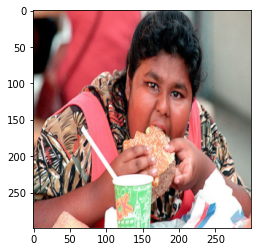

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a man is eating a hot dog in a hotel .<EOS>
<BOS> a man eats a hot dog with a fork .<EOS>
<BOS> a man with a white shirt and a white plate eating a sandwich .<EOS>
<BOS> a man holding a hot dog with a spoon in it .<EOS>
<BOS> a man with a piece of pizza on a plate .<EOS>
<BOS> a man is eating a slice of pizza .<EOS>
<BOS> a man in a white shirt is eating a sandwich .<EOS>
<BOS> a man is holding a hot dog in his hand .<EOS>
<BOS> a man is holding a hot dog with a spoon .<EOS>
<BOS> a man is holding a hot dog in his hand .<EOS>


In [ ]:
!wget https://s16.stc.all.kpcdn.net/share/i/12/5048737/inx960x640.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:57:00--  https://sok.media/wp-content/uploads/2019/02/za-stolom-4.jpg
Resolving sok.media (sok.media)... 104.26.2.147, 104.26.3.147, 172.67.70.129, ...
Connecting to sok.media (sok.media)|104.26.2.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47890 (47K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  46.77K  --.-KB/s    in 0.001s  

2020-06-29 22:57:01 (61.4 MB/s) - ‘img.jpg’ saved [47890/47890]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


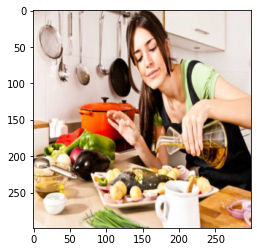

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a woman and a woman sitting at a table with a cake .<EOS>
<BOS> a woman is sitting at a table with a cake and a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman is sitting at a table with a cake .<EOS>
<BOS> a woman sitting at a table with a plate of food on it .<EOS>
<BOS> a woman is sitting at a table with a plate of food .<EOS>
<BOS> a woman in a kitchen preparing a meal .<EOS>
<BOS> a woman in a kitchen preparing food in a kitchen .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman is sitting at a table with a plate of food .<EOS>


In [ ]:
!wget https://sok.media/wp-content/uploads/2019/02/za-stolom-4.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:57:13--  https://sok.media/wp-content/uploads/2019/02/za-stolom.jpg
Resolving sok.media (sok.media)... 104.26.2.147, 104.26.3.147, 172.67.70.129, ...
Connecting to sok.media (sok.media)|104.26.2.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36901 (36K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  36.04K  --.-KB/s    in 0s      

2020-06-29 22:57:14 (93.3 MB/s) - ‘img.jpg’ saved [36901/36901]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


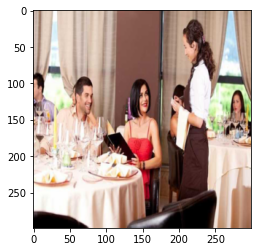

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a group of people sitting around a table with plates of food .<EOS>
<BOS> a group of people sitting at a table with a drink .<EOS>
<BOS> a group of people sitting around a table with plates of food .<EOS>
<BOS> a group of people sitting at a table with a pizza in front of them .<EOS>
<BOS> a group of people sitting at a table with a cake .<EOS>
<BOS> a group of people sitting around a table with plates of food .<EOS>
<BOS> a group of people sitting at a table with food .<EOS>
<BOS> a group of people sitting at a table with a cake .<EOS>
<BOS> a group of people sitting around a table .<EOS>
<BOS> a group of people sitting around a table with food .<EOS>


In [ ]:
!wget https://sok.media/wp-content/uploads/2019/02/za-stolom.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:57:27--  https://sok.media/wp-content/uploads/2019/02/za-stolom-2.jpg
Resolving sok.media (sok.media)... 104.26.2.147, 104.26.3.147, 172.67.70.129, ...
Connecting to sok.media (sok.media)|104.26.2.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33022 (32K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  32.25K  --.-KB/s    in 0s      

2020-06-29 22:57:29 (79.0 MB/s) - ‘img.jpg’ saved [33022/33022]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


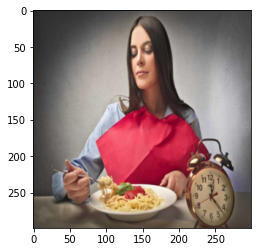

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a woman is sitting in a chair with a cake .<EOS>
<BOS> a woman is sitting in a chair with a laptop .<EOS>
<BOS> a woman in a pink shirt is holding a small white plate .<EOS>
<BOS> a woman is sitting on a table with a cake .<EOS>
<BOS> a woman sitting at a table with a birthday cake on it .<EOS>
<BOS> a woman in a blue shirt and a white shirt and a white tie .<EOS>
<BOS> a woman in a red shirt is sitting on a table<EOS>
<BOS> a woman is sitting in a chair with a laptop .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting on a table with a plate of food .<EOS>


In [ ]:
!wget https://sok.media/wp-content/uploads/2019/02/za-stolom-2.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:57:48--  https://s.pfst.net/2010.07/2183891170838c928853584e3cc3d9e9b88b137df5_b.jpg
Resolving s.pfst.net (s.pfst.net)... 94.130.239.75
Connecting to s.pfst.net (s.pfst.net)|94.130.239.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115870 (113K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 113.15K   210KB/s    in 0.5s    

2020-06-29 22:57:50 (210 KB/s) - ‘img.jpg’ saved [115870/115870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


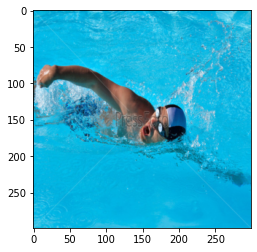

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a person is riding a surfboard on top of a wave .<EOS>
<BOS> a person on a surf board on a wave .<EOS>
<BOS> a man riding a surfboard on top of a wave .<EOS>
<BOS> a person on a surfboard in the ocean .<EOS>
<BOS> a person on a surfboard in the ocean .<EOS>
<BOS> a person on a surf board riding a wave<EOS>
<BOS> a person on a surf board in the ocean .<EOS>
<BOS> a person on a surfboard in the ocean .<EOS>
<BOS> a person on a surfboard in the ocean .<EOS>
<BOS> a person on a surfboard in the water .<EOS>


In [ ]:
!wget https://s.pfst.net/2010.07/2183891170838c928853584e3cc3d9e9b88b137df5_b.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-06-29 22:59:45--  https://s1.1zoom.ru/big0/835/Porsche_Roads_911_463738.jpg
Resolving s1.1zoom.ru (s1.1zoom.ru)... 88.99.134.39
Connecting to s1.1zoom.ru (s1.1zoom.ru)|88.99.134.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441307 (431K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 430.96K   407KB/s    in 1.1s    

2020-06-29 22:59:48 (407 KB/s) - ‘img.jpg’ saved [441307/441307]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


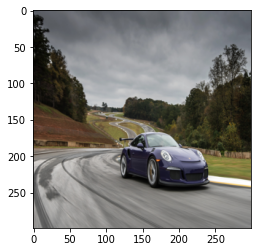

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a car driving down a street next to a car .<EOS>
<BOS> a car parked on a road with a car in the background .<EOS>
<BOS> a car driving down a road with a car in the background<EOS>
<BOS> a car parked on a street with a car in the background .<EOS>
<BOS> a car parked on the side of a road with a car .<EOS>
<BOS> a car parked on a road with a car in the background<EOS>
<BOS> a car parked on a road with a car in the background<EOS>
<BOS> a car parked on a road with a car in the background<EOS>
<BOS> a car parked on a road with a car in the background .<EOS>
<BOS> a car parked on a road in front of a car .<EOS>


In [ ]:
!wget https://s1.1zoom.ru/big0/835/Porsche_Roads_911_463738.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.2))

____


### Let's add Attention

In [ ]:
class CaptionNet_with_Attention(nn.Module):
    def __init__(self, n_tokens, max_len, device, emb_size=128, lstm_units=256,
                 cnn_feature_size=2048, num_LSTM_layers=1, dropout=0, teacher_forcing=True):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.emb_size = emb_size
        self.lstm_units = lstm_units
        self.cnn_feature_size = cnn_feature_size
        self.num_LSTM_layers = num_LSTM_layers
        self.max_len = max_len
        self.device = device
        self.teacher_forcing = teacher_forcing
        # two linear layers that will make the initial states h0 and c0 for the
        # LSTM from the vectors obtained from the Inseption output 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, num_LSTM_layers*lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, num_LSTM_layers*lstm_units)
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=0)

        self.rnn = nn.LSTM(emb_size, lstm_units, num_layers=num_LSTM_layers, batch_first=True)
        
        self.out = nn.Linear(lstm_units+cnn_feature_size, n_tokens)
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, containing the outputs of Inseption.
                shape: [batch, cnn_feature_size]
        :param captions_ix: target image description,  shape: [batch, word_i]

        :returns: logits for generated text description, shape: [batch, word_i, n_tokens]
        """
        batch_size = captions_ix.shape[0]
        input_len = captions_ix.shape[1]
        # initial_cell and initial_hid
        cell = self.cnn_to_c0(image_vectors).view(batch_size, self.num_LSTM_layers, -1).transpose(1,0).contiguous()
        hidden = self.cnn_to_h0(image_vectors).view(batch_size, self.num_LSTM_layers, -1).transpose(1,0).contiguous()
        

        # if self.teacher_forcing:
        captions_emb = self.emb(captions_ix)
        
        output, (hidden, cell) = self.rnn(captions_emb, (hidden, cell))

        #Attention
        attn_vec = torch.repeat_interleave(image_vectors.unsqueeze(1), repeats=input_len, dim=1)
        output = torch.cat((attn_vec, output), dim=-1)
        logits = self.out(output)
        assert logits.shape == (batch_size, input_len, self.n_tokens)

            
        return logits        

In [ ]:
model = CaptionNet_with_Attention(n_tokens=tokenizer.vocab_size(), max_len=max_sent_lenght, device=DEVICE,
                   num_LSTM_layers=2)
model.to(DEVICE)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [ ]:
train_2(model, optimizer, train_data, valid_data, generate_batch, num_iterations=4000, batch_size=700, device=DEVICE)

_________________________________
Iteration 90
train loss: 4.030162159601847
valid loss: 3.8358066082000732
_________________________________
Iteration 180
train loss: 3.2723162889480593
valid loss: 3.1891276836395264
_________________________________
Iteration 270
train loss: 2.9337996164957683
valid loss: 2.862699031829834
_________________________________
Iteration 360
train loss: 2.7085037231445312
valid loss: 2.6722609996795654
_________________________________
Iteration 450
train loss: 2.5570635398228965
valid loss: 2.5834670066833496
_________________________________
Iteration 540
train loss: 2.4738377968470258
valid loss: 2.426513671875
_________________________________
Iteration 630
train loss: 2.4014886140823366
valid loss: 2.4307823181152344
_________________________________
Iteration 720
train loss: 2.3509279171625774
valid loss: 2.409636974334717
_________________________________
Iteration 810
train loss: 2.29970121383667
valid loss: 2.374760866165161
_____________________

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/ModelsNotes/image_captioning_with_Attn(num_layers=2, emb_size=128,  lstm_units=256, cnn_feature_size=2048).pth')

### Let's see some generated descriptions of the model with Attention

In [ ]:
from matplotlib import pyplot as plt
from scipy.misc import imresize

--2020-07-06 12:59:52--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-07-06 12:59:52--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   422KB/s    in 0.2s    

2020-07-06 12:59:53 (422 KB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


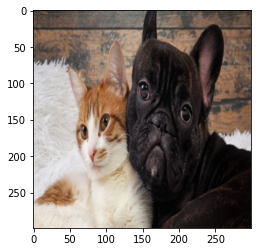

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a small dog is sitting on a couch .<EOS>
<BOS> a black and white cat is sitting on a couch<EOS>
<BOS> a black and white cat laying on a wooden floor .<EOS>
<BOS> a small dog is sitting on a couch .<EOS>
<BOS> a black and white cat laying on a couch .<EOS>
<BOS> a black dog laying on top of a couch .<EOS>
<BOS> a black and white cat is sitting on a couch .<EOS>
<BOS> a black and white cat sitting on a window sill .<EOS>
<BOS> a small dog is sitting on a couch .<EOS>
<BOS> a black and white cat sitting on a couch .<EOS>


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:00:21--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.120.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.120.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-07-06 13:00:21--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2020-07-06 13:00:21 (5.38 MB/s) - ‘img.jpg’ saved [54731/54731]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


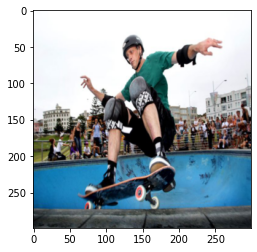

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a man in a black shirt doing a trick on a skateboard .<EOS>
<BOS> a man on a skateboard doing a trick on a skateboard .<EOS>
<BOS> a man jumping a skateboard over a ramp .<EOS>
<BOS> a skateboarder doing a trick on a skateboard .<EOS>
<BOS> a man on a skateboard jumping over a ramp .<EOS>
<BOS> a man in a blue shirt doing a trick on a skateboard .<EOS>
<BOS> a man on a skateboard jumping in the air<EOS>
<BOS> a man on a skateboard doing a trick on a skateboard .<EOS>
<BOS> a man jumping in the air on a skateboard .<EOS>
<BOS> a man is jumping high in the air on a skateboard .<EOS>


In [ ]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:01:37--  https://i.pinimg.com/474x/f7/f0/4e/f7f04e6a71cf48ae0a3be09849db4dcd.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.120.84, 2a02:26f0:ce:29b::1931, 2a02:26f0:ce:287::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|151.101.120.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60576 (59K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  59.16K  --.-KB/s    in 0.01s   

2020-07-06 13:01:37 (5.41 MB/s) - ‘img.jpg’ saved [60576/60576]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


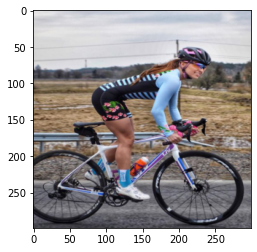

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a man riding a bike with a dog on top of it .<EOS>
<BOS> a man riding a bike on a beach next to a lamp .<EOS>
<BOS> a person riding a bike with a dog on the back of it .<EOS>
<BOS> a person riding a bike next to a bike<EOS>
<BOS> a woman riding a bike next to a bicycle .<EOS>
<BOS> a person riding a bike on a beach<EOS>
<BOS> a woman riding a bike through a parking lot .<EOS>
<BOS> a person riding a bike on a street .<EOS>
<BOS> a man riding a bike and a dog on a bike .<EOS>
<BOS> a man riding on a bike with a dog on the back .<EOS>


In [ ]:
!wget https://i.pinimg.com/474x/f7/f0/4e/f7f04e6a71cf48ae0a3be09849db4dcd.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:01:04--  https://cdn.lifehacker.ru/wp-content/uploads/2012/07/01_1496913721-1140x570.jpg
Resolving cdn.lifehacker.ru (cdn.lifehacker.ru)... 136.243.37.177
Connecting to cdn.lifehacker.ru (cdn.lifehacker.ru)|136.243.37.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125641 (123K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 122.70K  --.-KB/s    in 0.05s   

2020-07-06 13:01:04 (2.48 MB/s) - ‘img.jpg’ saved [125641/125641]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


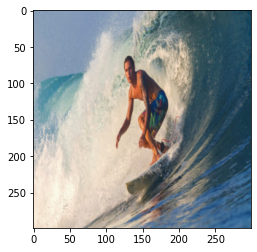

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a surfer rides a wave in the ocean .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a surfer riding a wave on a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>
<BOS> a man riding a wave on top of a surfboard .<EOS>


In [ ]:
!wget https://cdn.lifehacker.ru/wp-content/uploads/2012/07/01_1496913721-1140x570.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:02:22--  https://s16.stc.all.kpcdn.net/share/i/12/5048737/inx960x640.jpg
Resolving s16.stc.all.kpcdn.net (s16.stc.all.kpcdn.net)... 185.31.112.73
Connecting to s16.stc.all.kpcdn.net (s16.stc.all.kpcdn.net)|185.31.112.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238131 (233K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 232.55K  --.-KB/s    in 0.1s    

2020-07-06 13:02:23 (2.08 MB/s) - ‘img.jpg’ saved [238131/238131]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


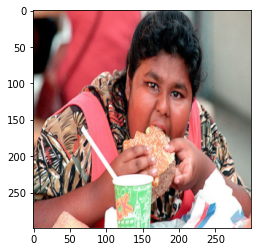

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a woman is taking a bite of a donut .<EOS>
<BOS> a man eating a donut with a bite taken out of it .<EOS>
<BOS> a woman is eating a donut and a cup of coffee .<EOS>
<BOS> a person is holding a small donut<EOS>
<BOS> a person is eating a donut with a bite taken out of it .<EOS>
<BOS> a person is eating a donut with a bite taken out of it .<EOS>
<BOS> a person is eating a donut with a bite taken out of it .<EOS>
<BOS> a person is eating a donut and some fun<EOS>
<BOS> a person is eating a donut with a bite taken out of it<EOS>
<BOS> a person is eating a doughnut with a donut<EOS>


In [ ]:
!wget https://s16.stc.all.kpcdn.net/share/i/12/5048737/inx960x640.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:02:54--  https://sok.media/wp-content/uploads/2019/02/za-stolom-4.jpg
Resolving sok.media (sok.media)... 104.26.2.147, 104.26.3.147, 172.67.70.129, ...
Connecting to sok.media (sok.media)|104.26.2.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47890 (47K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  46.77K  --.-KB/s    in 0s      

2020-07-06 13:02:54 (109 MB/s) - ‘img.jpg’ saved [47890/47890]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


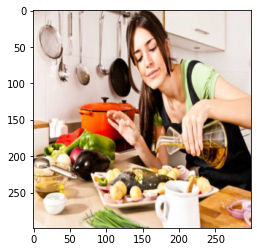

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a knife over her owner .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>
<BOS> a woman sitting at a table with a plate of food .<EOS>


In [ ]:
!wget https://sok.media/wp-content/uploads/2019/02/za-stolom-4.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:03:05--  https://sok.media/wp-content/uploads/2019/02/za-stolom.jpg
Resolving sok.media (sok.media)... 104.26.3.147, 104.26.2.147, 172.67.70.129, ...
Connecting to sok.media (sok.media)|104.26.3.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36901 (36K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  36.04K  --.-KB/s    in 0s      

2020-07-06 13:03:05 (88.6 MB/s) - ‘img.jpg’ saved [36901/36901]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


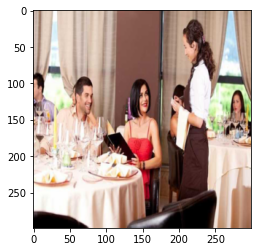

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a group of people sitting around a table .<EOS>
<BOS> a group of people sitting around a table with a laptop .<EOS>
<BOS> a group of people sitting around a table with a laptop .<EOS>
<BOS> a group of people sitting around a table .<EOS>
<BOS> a group of people sitting around a table with a laptop .<EOS>
<BOS> a group of people sitting around a table .<EOS>
<BOS> a group of people sitting around a table with a laptop .<EOS>
<BOS> a group of people sitting around a table .<EOS>
<BOS> a group of people sitting around a table eating food .<EOS>
<BOS> a group of people sitting around a table with a laptop .<EOS>


In [ ]:
!wget https://sok.media/wp-content/uploads/2019/02/za-stolom.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:03:38--  https://sok.media/wp-content/uploads/2019/02/za-stolom-2.jpg
Resolving sok.media (sok.media)... 104.26.2.147, 172.67.70.129, 104.26.3.147, ...
Connecting to sok.media (sok.media)|104.26.2.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33022 (32K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  32.25K  --.-KB/s    in 0s      

2020-07-06 13:03:38 (114 MB/s) - ‘img.jpg’ saved [33022/33022]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


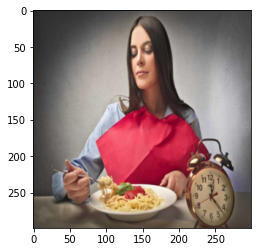

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a woman is sitting on a table with a clock .<EOS>
<BOS> a woman with a red pants and a red and black tank top<EOS>
<BOS> a woman with a red and white top and a red and white clock<EOS>
<BOS> a woman that is sitting on a table with a clock .<EOS>
<BOS> a woman is sitting on a table with a clock .<EOS>
<BOS> a woman standing in front of a large clock .<EOS>
<BOS> a woman standing in a room with a clock .<EOS>
<BOS> a woman sitting on a red and white table with a clock .<EOS>
<BOS> a woman sitting at a table with a clock .<EOS>
<BOS> a woman standing next to a woman on a bed .<EOS>


In [ ]:
!wget https://sok.media/wp-content/uploads/2019/02/za-stolom-2.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:03:51--  https://s.pfst.net/2010.07/2183891170838c928853584e3cc3d9e9b88b137df5_b.jpg
Resolving s.pfst.net (s.pfst.net)... 94.130.239.75
Connecting to s.pfst.net (s.pfst.net)|94.130.239.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115870 (113K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 113.15K  --.-KB/s    in 0.02s   

2020-07-06 13:03:52 (4.77 MB/s) - ‘img.jpg’ saved [115870/115870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


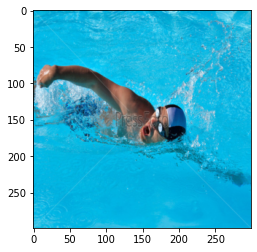

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a dog laying on top of a sandy beach .<EOS>
<BOS> a person on a surfboard in the water .<EOS>
<BOS> a person riding a wave on a surfboard .<EOS>
<BOS> a dog laying on the ground next to a blue water .<EOS>
<BOS> a man is laying on a surfboard in the water .<EOS>
<BOS> a person riding a surf board on a wave<EOS>
<BOS> a person is riding a wave on a surfboard .<EOS>
<BOS> a dog laying on the ground with a surfboard .<EOS>
<BOS> a person is riding a board on a wave<EOS>
<BOS> a dog laying on top of a blue surf board .<EOS>


In [ ]:
!wget https://s.pfst.net/2010.07/2183891170838c928853584e3cc3d9e9b88b137df5_b.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.3))

--2020-07-06 13:04:35--  https://s1.1zoom.ru/big0/835/Porsche_Roads_911_463738.jpg
Resolving s1.1zoom.ru (s1.1zoom.ru)... 88.99.134.39
Connecting to s1.1zoom.ru (s1.1zoom.ru)|88.99.134.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441307 (431K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 430.96K  --.-KB/s    in 0.1s    

2020-07-06 13:04:35 (3.40 MB/s) - ‘img.jpg’ saved [441307/441307]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


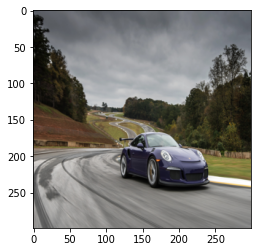

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a car driving down a road with cars parked on the side of the road .<EOS>
<BOS> a car driving down a road with cars parked on the side of the road .<EOS>
<BOS> a car driving down a road with cars parked on the side of the road .<EOS>
<BOS> a car driving down a road next to a car .<EOS>
<BOS> a car driving down a road with cars parked on the side of the road .<EOS>
<BOS> a car driving down a road in a parking lot .<EOS>
<BOS> a car driving down a road next to a roadside car .<EOS>
<BOS> a car driving down a road with cars driving around .<EOS>
<BOS> a car driving down a road with a motorcycle parked on the side of the road .<EOS>
<BOS> a car is driving down a road next to a car .<EOS>


In [ ]:
!wget https://s1.1zoom.ru/big0/835/Porsche_Roads_911_463738.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.2))

--2020-07-06 13:07:40--  https://st.depositphotos.com/1158226/2657/i/450/depositphotos_26578407-stock-photo-green-fields-of-wheat-in.jpg
Resolving st.depositphotos.com (st.depositphotos.com)... 23.42.196.238
Connecting to st.depositphotos.com (st.depositphotos.com)|23.42.196.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69204 (68K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  67.58K  --.-KB/s    in 0.02s   

2020-07-06 13:07:40 (3.75 MB/s) - ‘img.jpg’ saved [69204/69204]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


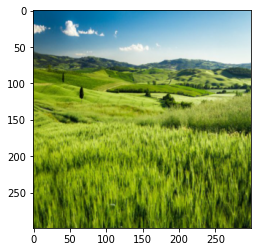

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a herd of cows grazing in a grassy field .<EOS>
<BOS> a herd of sheep standing on top of a lush green field .<EOS>
<BOS> a herd of sheep grazing on a lush green field .<EOS>
<BOS> a herd of sheep grazing in a grassy field .<EOS>
<BOS> a herd of sheep grazing on a lush green field .<EOS>
<BOS> a herd of sheep grazing on a lush green hillside .<EOS>
<BOS> a herd of sheep grazing on a lush green field .<EOS>
<BOS> a giraffe is standing in a field near a hill .<EOS>
<BOS> a herd of sheep grazing on a lush green field .<EOS>
<BOS> a herd of sheep grazing in a grassy field .<EOS>


In [ ]:
!wget https://st.depositphotos.com/1158226/2657/i/450/depositphotos_26578407-stock-photo-green-fields-of-wheat-in.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.2))

--2020-07-06 13:08:51--  https://artchive.ru/res/media/img/oy800/work/4b8/287087@2x.webp
Resolving artchive.ru (artchive.ru)... 212.129.48.12
Connecting to artchive.ru (artchive.ru)|212.129.48.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2063114 (2.0M) [image/webp]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]   1.97M  --.-KB/s    in 0.04s   

2020-07-06 13:08:51 (51.6 MB/s) - ‘img.jpg’ saved [2063114/2063114]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


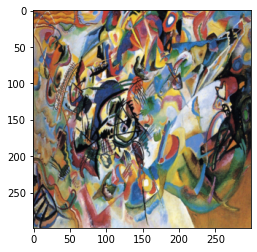

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a bunch of people that are sitting on a bed .<EOS>
<BOS> a bunch of different types of food on a table .<EOS>
<BOS> a bunch of different types of food on a table .<EOS>
<BOS> a bunch of different types of vegetables on a table .<EOS>
<BOS> a group of people sitting around a table with a large camera .<EOS>
<BOS> a bunch of people that are sitting on a bed .<EOS>
<BOS> a bunch of different types of food on a table .<EOS>
<BOS> a bunch of different types of vegetables on a table .<EOS>
<BOS> a bunch of colorful sandwiches and a microwave<EOS>
<BOS> a bunch of different types of food on a table .<EOS>


In [ ]:
!wget https://artchive.ru/res/media/img/oy800/work/4b8/287087@2x.webp -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.2))

--2020-07-06 13:15:04--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/450px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81170 (79K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  79.27K  --.-KB/s    in 0.01s   

2020-07-06 13:15:04 (6.76 MB/s) - ‘img.jpg’ saved [81170/81170]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


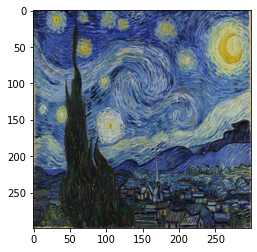

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<BOS> a man is holding a large piece of luggage .<EOS>
<BOS> a man is doing a trick on a skateboard .<EOS>
<BOS> a man is holding a large piece of pizza .<EOS>
<BOS> a person standing in a room with a large teddy bear .<EOS>
<BOS> a man is holding a large piece of luggage .<EOS>
<BOS> a man is practicing his tricks on a skateboard .<EOS>
<BOS> a man is practicing his head to a pair of scissors .<EOS>
<BOS> a man is practicing his tricks on a skateboard .<EOS>
<BOS> a person is holding a pair of scissors .<EOS>
<BOS> a man is holding a pair of scissors .<EOS>


In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/450px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(generate_caption(model, img, greedy_mode=False, temperature=0.2))

### Conclusions

The architecture with Attention shows no obvious improvement in the quality of the network. Both architectures (with and without Attention) generate grammatically and semantically correct descriptions in most cases, if the picture shows that < someone > < is doing > < something > (this happens because of the dataset, it is not the network's fault).

The final version of the architecture contains 2 LSTM layers, although experiments have shown that 1 LSTM layer produced approximately the same quality descriptions.

Training was performed with teaching_forcing = 1, because with other values of this parameter the quality of the network deteriorated.